In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 10
import numpy as np
import pandas as pd

color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y'
}

# periods = [('2024-07-11', '2024-07-18'),     # PERIODS FOR ALL TIME
#            ('2024-07-18', '2024-07-23'), 
#            ('2024-07-23', '2024-08-15'), 
#            ('2024-08-15', '2024-09-03'),
#            ('2024-09-03', '2024-09-10'), 
#            ]

periods = [('2024-07-11', '2024-07-17'),  # PERIODS FOR JUST CLOVER
           ('2024-07-18', '2024-07-24'), 
           ('2024-07-24', '2024-07-30')
           ]

periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in periods]

clover_start = pd.to_datetime('2024-07-11')
clover_end = pd.to_datetime('2024-07-30')

In [2]:
# STIMULUS SHUFFLE INTERVALS
stim_ints = pd.read_csv('csvs/stimulus_intervals.csv', index_col=False)
stim_ints['interval'] = stim_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(')')), 
                                                            closed='left'))

# CAMERA ON TIME INTERVALS
cam_ints = pd.read_csv('csvs/camera_intervals.csv', index_col=False)
cam_ints['interval'] = cam_ints['interval'].apply(lambda x: pd.Interval(pd.Timestamp(x.split(', ')[0].strip('[')), 
                                                            pd.Timestamp(x.split(', ')[1].strip(']')), 
                                                            closed='both'))

In [3]:
# LOAD ORIGINAL BOMBUS ID DATA
bombus_df = pd.read_csv('csvs/clean_dfs/bombus_df_manualedit.csv')
bombus_df['datetime'] = pd.to_datetime(bombus_df['datetime'])
# bombus_df

In [4]:
# LOAD IN AND FORMAT NEW SAHI DETECTIONS, CONCAT TO BOMBUS_DF
sahi_detections = pd.read_csv('csvs/bees_to_id_091625LRBupdate.csv', index_col=False)
sahi_detections[['pi', 'datetime']] = sahi_detections['imageID'].str.extract(r'^pi(\d+)_(\d{8}_\d{6})')
sahi_detections['datetime'] = pd.to_datetime(sahi_detections['datetime'], format='%Y%m%d_%H%M%S')
sahi_detections = sahi_detections.drop(columns=['caste', 'taxonomicNotes'])
sahi_detections['species'] = sahi_detections['species'].str[7:]
sahi_detections['species'] = sahi_detections['species'].replace('','unk')
sahi_detections.columns = ['filename', 'species', 'sex', 'pi', 'datetime']
sahi_detections['pi'] = sahi_detections['pi'].astype(int)
sahi_detections['sex'] = sahi_detections['sex'].fillna('unk')
bombus_df = pd.concat([bombus_df, sahi_detections], ignore_index=True)
bombus_df = bombus_df.sort_values(by=['pi', 'datetime'], ascending=[True, True]).reset_index(drop=True)

In [5]:
# APPLY TREATMENT COLOR TO ROWS BASED ON STIMULUS SHUFFLE INTERVALS
bombus_df['color'] = None
for _, row in stim_ints.iterrows():
    mask = (bombus_df['pi'] == row['pi']) & (bombus_df['datetime'].between(row['interval'].left, row['interval'].right, inclusive='left'))
    bombus_df.loc[mask, 'color'] = row['color']
bombus_df = bombus_df.drop(columns=['filename', 'date', 'time_diff'])
bombus_df = bombus_df[['pi', 'datetime', 'color', 'species', 'sex']]

In [6]:
# LOAD AND FORMAT LONG VISITS (WERE EXCLUDED FROM FULL IMAGE LIST FOR ID SIMPLICITY)
long_visits = pd.read_csv('csvs/stationary_bombus_filelist.txt', header=None, names=['filename'])
long_visits[['pi', 'datetime']] = long_visits['filename'].str.extract(r'^pi(\d+)_(\d{8}_\d{6})')
long_visits['pi'] = long_visits['pi'].astype(int)
long_visits = long_visits.drop(columns='filename')
long_visits['datetime'] = pd.to_datetime(long_visits['datetime'], format='%Y%m%d_%H%M%S')
long_visits = long_visits.sort_values(by=['pi', 'datetime'], ascending=[True, True]).reset_index(drop=True)

In [7]:
# ADD LONG VISITS TO ORIGINAL VISITS
combined_df = pd.concat([bombus_df, long_visits], ignore_index=True)
combined_df = combined_df.sort_values(by=['pi', 'datetime'])
columns_to_fill = ['species', 'sex', 'color']
combined_df[columns_to_fill] = combined_df[columns_to_fill].ffill()
combined_df['time_diff'] = combined_df.groupby(['pi', 'color', 'species', 'sex'])['datetime'].diff()
combined_df['new_visit'] = (combined_df['time_diff'] > pd.Timedelta(seconds=4)) | (combined_df['time_diff'].isna())
combined_df['visit_id'] = combined_df.groupby(['species'])['new_visit'].cumsum()
combined_df['time_diff_seconds'] = combined_df['time_diff'].dt.total_seconds()
combined_df_clover = combined_df[combined_df['datetime'] < clover_end]

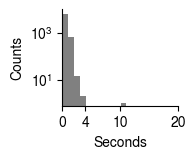

In [37]:
# PLOT HISTOGRAM OF SECONDS BETWEEN CONSECUTIVE SAME-SPECIES IMAGES

time_diff_distribution = combined_df_clover['time_diff_seconds']
bin_size = 1
bins = np.arange(1,20 + bin_size, bin_size) - .9

plt.figure(figsize=(1.5,1.25))
plt.hist(time_diff_distribution[time_diff_distribution < 20], bins=bins, color='gray', log=True)
# plt.yticks([1, 10, 100, 1000, 10000])
plt.ylim(.8,10000)
plt.xticks([0,4,10,20])
plt.xlim(0, 20)
plt.ylabel('Counts')
# plt.yscale("log")
plt.xlabel('Seconds')
# plt.tight_layout()

plt.savefig('figs/timediff_small.svg', format='svg')

In [9]:
# CALCULATE VISIT DURATIONS
visit_durations = (
    combined_df.groupby(['species', 'visit_id', 'pi', 'color'])['datetime']
    .agg(visit_start='min', visit_end='max')
    .reset_index())
visit_durations['duration'] = ((visit_durations['visit_end'] - visit_durations['visit_start']).dt.total_seconds())
visit_durations['pi_color'] = visit_durations['pi'].astype(str) + '_' + visit_durations['color']
visit_durations = visit_durations.sort_values(by='visit_start').reset_index(drop=True)

In [10]:
# MANUALLY ADD VISITS FOR EDGE CASE WITH MULTIPLE BEES IN ONE IMAGE

def add_rows(df, new_rows):
    new_df = pd.DataFrame(new_rows)
    new_df['visit_start'] = pd.to_datetime(new_df['visit_start'])
    new_df['visit_end'] = pd.to_datetime(new_df['visit_end'])
    new_df['duration'] = (new_df['visit_end'] - new_df['visit_start']).dt.total_seconds()
    for pi_color in new_df['pi_color'].unique():
        if pd.notna(pi_color):
            max_existing_id = df[df['pi_color'] == pi_color]['visit_id'].max()
            max_existing_id = max_existing_id if pd.notna(max_existing_id) else 0
            new_df.loc[new_df['pi_color'] == pi_color, 'visit_id'] = range(
                int(max_existing_id) + 1, int(max_existing_id) + 1 + len(new_df[new_df['pi_color'] == pi_color])
            )

    df = pd.concat([df, new_df], ignore_index=True)
    
    return df

new_rows = [
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 09:41:43', 'visit_end': '2024-07-23 10:02:38',
        'pi_color': '9_grn'
    },
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 10:02:19', 'visit_end': '2024-07-23 10:07:09',
        'pi_color': '9_grn'
    },
    {
        'species': 'vosnesenskii', 'pi': 9, 'color': 'grn',
        'visit_start': '2024-07-23 10:02:35', 'visit_end': '2024-07-23 10:05:19',
        'pi_color': '9_grn'
    }
]

visit_durations = add_rows(visit_durations, new_rows)

In [11]:
cumulative_visits = visit_durations.groupby(['pi_color', 'visit_start']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')
cumulative_color_visits = visit_durations.groupby(['color', 'visit_start']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')

visit_duration_distribution = visit_durations['duration']

# visit_durations.to_csv('csvs/bombus_visit_durations.csv', index=False)

### Calculate rate of bee capture in clover vs bare

In [ ]:
threshold = pd.to_datetime('2024-07-30')

visit_durations_clover = visit_durations[visit_durations['visit_end'] < threshold]
visit_durations_bare = visit_durations[visit_durations['visit_end'] > threshold]

visit_counts_clover = len(visit_durations[visit_durations['visit_end'] < threshold])
visit_counts_bare = len(visit_durations[visit_durations['visit_end'] > threshold])

cam_ints['duration'] = cam_ints['interval'].apply(lambda x: x.right - x.left)
before_or_on = cam_ints[cam_ints['interval'].apply(lambda x: x.right < threshold)]
after = cam_ints[cam_ints['interval'].apply(lambda x: x.left > threshold)]
total_before_or_on = before_or_on['duration'].sum()
total_after = after['duration'].sum()

print("Total duration of intervals ending on or before 2024-07-30 (seconds):", total_before_or_on.total_seconds())
print("Total duration of intervals starting after 2024-07-30 (seconds):", total_after.total_seconds())
print()
print('visit counts clover:', visit_counts_clover)
print('visit counts bare:', visit_counts_bare)
print()
print(f'clover avg visits per trap per day: {(visit_counts_clover/(total_before_or_on.total_seconds()/3600/14))}')
print(f'bare avg visits per trap per day: {(visit_counts_bare/(total_after.total_seconds()/3600/14))}')


visit_durations_clover.to_csv('csvs/visit_durations_clover.csv', index=False)

Total duration of intervals ending on or before 2024-07-30 (seconds): 6970149.0
Total duration of intervals starting after 2024-07-30 (seconds): 13302447.0

visit counts clover: 291
visit counts bare: 16

clover avg visits per trap per day: 2.1041730958692564
bare avg visits per trap per day: 0.060620425700624855


In [ ]:
# EXTRACT DAILY VISIT COUNTS FOR CONTRAST ONLY - USED IN NB7
cnt_clover_visits = visit_durations_clover[visit_durations_clover['color'] == 'cnt']
cnt_clover_visits['date'] = cnt_clover_visits['visit_start'].dt.date
cnt_clover_daily_visit_count = cnt_clover_visits.groupby(['pi','date']).size().reset_index(name='visit_count').sort_values('date')
cnt_clover_daily_visit_count.to_csv('csvs/cnt_clover_daily_visit_count.csv', index=False)

/tmp/ipykernel_29090/4064082101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnt_clover_visits['date'] = cnt_clover_visits['visit_start'].dt.date


In [ ]:
# EXTRACT DAILY CAM TIME TOTAL FOR CONTRAST ONLY - USED IN NB7
cnt_clover_ints = before_or_on[before_or_on['color'] == 'cnt']
cnt_clover_ints['date'] = cnt_clover_ints['interval'].apply(lambda x: x.left).dt.date
cnt_clover_total_time = cnt_clover_ints.groupby(['pi',"date"])['duration'].sum().reset_index()


/tmp/ipykernel_29090/4188918615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnt_clover_ints['date'] = cnt_clover_ints['interval'].apply(lambda x: x.left).dt.date


In [147]:
cnt_visits_per_hr = pd.merge(cnt_clover_daily_visit_count, cnt_clover_total_time, on=['pi','date'], how='outer').sort_values('date').reset_index(drop=True).fillna(0)
cnt_visits_per_hr['hours'] = cnt_visits_per_hr['duration'].dt.total_seconds()/3600
cnt_visits_per_hr['visits_per_hr'] = cnt_visits_per_hr['visit_count']/cnt_visits_per_hr['hours']

print(f"Contrast trap visits per hour: Mean = {cnt_visits_per_hr['visits_per_hr'].mean():.4f}, SD = {cnt_visits_per_hr['visits_per_hr'].std():.4f}")

Contrast trap visits per hour: Mean = 0.2327, SD = 0.2722


In [148]:
cnt_visits_per_hr.to_csv('csvs/cnt_visits_per_hour.csv', index=False)

In [14]:
# NUMBER OF VISITS PER STIMULUS
visit_durations_clover.groupby('color').size()

color
blu    36
blv    54
cnt    95
grn    71
yel    35
dtype: int64

### VISIT COUNTS BY HOUR OF DAY

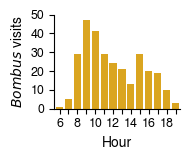

In [40]:
total_counts_per_hour = visit_durations_clover['visit_start'].dt.hour.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(2, 1.7))
ax.bar(total_counts_per_hour.index, total_counts_per_hour, color='goldenrod')
ax.set_xlabel('Hour')
ax.set_ylabel(r'$\it{Bombus}$ visits')

plt.ylim(0, 50)
plt.yticks([0, 10, 20, 30, 40, 50], fontsize=9)
plt.xlim(5.4, 19.5)

xticks = total_counts_per_hour.index
xlabels = ['6','7','8','9','10','11','12','13','14','15','16','17','18','19']
xlabels = ['6','','8','','10','','12','','14','','16','','18','']
plt.xticks(xticks, labels=xlabels, fontsize=9)

plt.tight_layout()
plt.savefig('figs/bombus_visits_hourly.svg', format='svg')

### Subsample early 1hz Pis (how does phase of subsampling affect visit counts):

-- RERUN PHASE GENERATION


In [16]:
onehz_camtimes_pi3 = pd.read_csv('csvs/onehz_visits_pi3.csv', index_col=0, parse_dates=['datetime'])
onehz_camtimes_pi10 = pd.read_csv('csvs/onehz_visits_pi10.csv', index_col=0, parse_dates=['datetime'])

pi3_subsampled_p0 = onehz_camtimes_pi3.iloc[::2]
pi3_subsampled_p1 = onehz_camtimes_pi3.iloc[1::2]
pi10_subsampled_p0 = onehz_camtimes_pi10.iloc[::2]
pi10_subsampled_p1 = onehz_camtimes_pi10.iloc[1::2]

onehz_visits_pi3 = combined_df[(combined_df['pi'] == 3) & (combined_df['datetime'] < '2024-07-17')]
onehz_visits_pi10 = combined_df[(combined_df['pi'] == 10) & (combined_df['datetime'] < '2024-07-17')]
shortvisits_pi3 = onehz_visits_pi3[onehz_visits_pi3['visit_id'] != 46]

In [17]:
print(f'pi3 phase 0 = {len(pi3_subsampled_p0[pi3_subsampled_p0['datetime'].isin(shortvisits_pi3['datetime'])])}')
print(f'pi3 phase 1 = {len(pi3_subsampled_p1[pi3_subsampled_p1['datetime'].isin(shortvisits_pi3['datetime'])])}\n')

print(f'pi10 phase 0 = {len(pi10_subsampled_p0[pi10_subsampled_p0['datetime'].isin(onehz_visits_pi10['datetime'])])}')
print(f'pi10 phase 1 = {len(pi10_subsampled_p1[pi10_subsampled_p1['datetime'].isin(onehz_visits_pi10['datetime'])])}')

pi3 phase 0 = 14
pi3 phase 1 = 15

pi10 phase 0 = 4
pi10 phase 1 = 3


### Calculate visits per 10k photos each day

In [18]:
# AVG DURATION OF VISIT PER COLOR
visit_durations['duration_adj'] = visit_durations['duration'] + 1
color_visit_durations = visit_durations.groupby('color')['duration_adj'].sum().astype(int)
color_total_counts = visit_durations.groupby('color')['pi'].count()
color_visit_durations / color_total_counts

color
blu     2.025641
blv     1.129032
cnt    21.255102
grn    78.746479
yel    53.810811
dtype: float64

In [19]:
cumulative_color_visits['date'] = cumulative_color_visits['visit_start'].dt.date
cumulative_color_visit_counts = cumulative_color_visits.groupby(['color','date']).size().reset_index(name='visit_count')

In [20]:
date_photo_counts = pd.read_csv('csvs/date_color_counts.csv', index_col=False)
date_photo_counts['date'] = pd.to_datetime(date_photo_counts['date']).dt.date
date_photo_counts['count_per_10k'] = date_photo_counts['count']/10000
date_photo_counts

,color,date,count,count_per_10k
0,blu,2024-07-11,18400,1.8400
1,blu,2024-07-12,18400,1.8400
2,blu,2024-07-13,26524,2.6524
3,blu,2024-07-14,53297,5.3297
4,blu,2024-07-15,35075,3.5075
...,...,...,...,...
269,yel,2024-08-29,47623,4.7623
270,yel,2024-08-30,42781,4.2781
271,yel,2024-09-03,33030,3.3030
272,yel,2024-09-04,47499,4.7499


### NUMBER OF IMAGES TAKEN FOR EACH COLOR

In [21]:
clover_date_photo_counts = date_photo_counts[date_photo_counts['date'] < pd.to_datetime('2024-07-30').date()]
clover_date_photo_counts.groupby('color')['count'].sum()

color
blu    1061467
blv    1090255
cnt    1157578
grn    1185447
yel    1212146
Name: count, dtype: int64

### PLOT CUMULATIVE VISIT COUNTS

In [22]:
merge_photos_visits = pd.merge(date_photo_counts, cumulative_color_visit_counts, on=['color', 'date'], how='inner')
merge_photos_visits['visits_per_10k'] = merge_photos_visits['visit_count']/merge_photos_visits['count_per_10k']
# merge_photos_visits['cumulative_visits'] = merge_photos_visits.groupby('color')['visits_per_10k'].cumsum()
merge_photos_visits
merge_photos_visits_filtered = merge_photos_visits[merge_photos_visits['date'] <= merge_photos_visits['date'].min() + pd.Timedelta(days=18)]
merge_photos_visits_filtered['date'] = pd.to_datetime(merge_photos_visits_filtered['date'])
merge_photos_visits_filtered['day'] = (merge_photos_visits_filtered['date'] - merge_photos_visits_filtered['date'].min()).dt.days +1
merge_photos_visits_filtered['cumulative_visits'] = merge_photos_visits_filtered.groupby('color')['visit_count'].cumsum()
merge_photos_visits_filtered

/tmp/ipykernel_29090/2762496499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_photos_visits_filtered['date'] = pd.to_datetime(merge_photos_visits_filtered['date'])
/tmp/ipykernel_29090/2762496499.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_photos_visits_filtered['day'] = (merge_photos_visits_filtered['date'] - merge_photos_visits_filtered['date'].min()).dt.days +1
/tmp/ipykernel_29090/2762496499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,color,date,count,count_per_10k,visit_count,visits_per_10k,day,cumulative_visits
0,blu,2024-07-11,18400,1.8400,1,0.543478,1,1
1,blu,2024-07-12,18400,1.8400,1,0.543478,2,2
2,blu,2024-07-13,26524,2.6524,3,1.131051,3,5
3,blu,2024-07-14,53297,5.3297,4,0.750511,4,9
4,blu,2024-07-15,35075,3.5075,2,0.570207,5,11
...,...,...,...,...,...,...,...,...
85,yel,2024-07-25,92735,9.2735,1,0.107834,15,29
86,yel,2024-07-26,92779,9.2779,1,0.107783,16,30
87,yel,2024-07-27,92584,9.2584,3,0.324030,17,33
88,yel,2024-07-28,92810,9.2810,1,0.107747,18,34


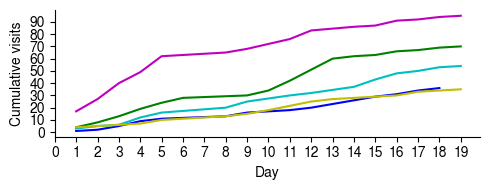

In [23]:
plt.figure(figsize=(5, 2))

for color, group in merge_photos_visits_filtered.groupby('color'):
    plt.plot(group['day'], group['cumulative_visits'],
             label=color, color=color_map.get(color))

plt.xlabel('Day')
plt.ylabel('Cumulative visits')
plt.yticks(range(0,100, 10))
plt.xticks(range(0,20))

plt.tight_layout()
# plt.savefig('figs/cumulative_visits_per_10k.svg', format='svg')

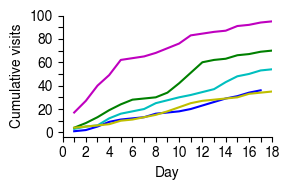

In [42]:

SKIPPED_DAYS = {6}

def day_to_display_index(d_cal: int) -> int:
    return d_cal - sum(1 for sd in SKIPPED_DAYS if sd < d_cal)

plt.figure(figsize=(3, 2))

for color, group in merge_photos_visits_filtered.groupby('color'):
    disp_days = group['day'].apply(day_to_display_index)
    plt.plot(disp_days, group['cumulative_visits'],
             label=color, color=color_map.get(color))

plt.xlabel('Day')
plt.ylabel('Cumulative visits')
ticks = range(0, 110, 10)
labels = [str(d) if d % 20 == 0 else "" for d in ticks]
plt.yticks(ticks, labels)

cal_days = [d for d in range(0, 19) if d not in SKIPPED_DAYS]
disp_days = [day_to_display_index(d) for d in cal_days]

ticks = range(0, 19)
labels = [str(d) if d % 2 == 0 else "" for d in ticks]
plt.xticks(ticks, labels)
plt.xlim(0,18)

plt.tight_layout()
plt.savefig('figs/cumulative_visits_small.svg', format='svg')

/tmp/ipykernel_29090/1690918966.py:106: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  coll = BrokenBarHCollection(


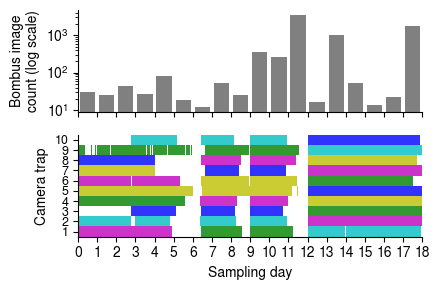

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.collections import BrokenBarHCollection

combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
day0 = combined_df['datetime'].dt.floor('D').min()
combined_df['day'] = (combined_df['datetime'].dt.floor('D') - day0).dt.days
SKIPPED_DAYS = {6}

def day_to_display_index(d_cal: int) -> int:
    return d_cal - sum(1 for sd in SKIPPED_DAYS if sd < d_cal)

daily_counts = (
    combined_df
    .groupby('day')
    .size()
    .reset_index(name='count')
)
daily_counts['cum_count'] = daily_counts['count'].cumsum()
daily_counts = daily_counts[(daily_counts['day'] <= 18) & (~daily_counts['day'].isin(SKIPPED_DAYS))]
daily_counts['disp_day'] = daily_counts['day'].apply(day_to_display_index)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True, gridspec_kw={'height_ratios':[1,1]})

ax1.bar(daily_counts['disp_day'] + 0.5, daily_counts['count'], color='gray', width=0.8)
ax1.set_ylabel("Bombus image\ncount (log scale)")
ax1.set_yscale("log")

day0_date = clover_start.date()

def day_window(datet):
    d = (datet.date() - day0_date).days
    if d <= 6:
        ws, we = (5, 0), (16, 0)
    elif d > 6 and d <= 12:
        ws, we = (5, 0), (19, 0)
    else:
        ws, we = (6, 0), (20, 0)
    tz = getattr(datet, 'tzinfo', None)
    wstart = dt.datetime.combine(datet.date(), dt.time(*ws), tz)
    wend   = dt.datetime.combine(datet.date(), dt.time(*we), tz)
    return d, wstart, wend

def compressed_x(t):
    d_cal, wstart, wend = day_window(t)
    base = float(day_to_display_index(d_cal))
    if t <= wstart:
        return base
    if t >= wend:
        return base + 1.0
    frac = (t - wstart) / (wend - wstart)
    return base + float(frac)

TOL = 1e-12
ROUND = 12
def _rx(x): return float(round(x, ROUND))

period_subset = cam_ints[
    cam_ints['interval'].apply(lambda x: clover_start <= x.left and x.right <= clover_end)
]

pis = sorted(period_subset['pi'].unique())
segments_by_pi = {pi: [] for pi in pis}

def add_seg(pi, ldt, rdt, color_key):
    x1 = _rx(compressed_x(ldt))
    x2 = _rx(compressed_x(rdt))
    if x2 <= x1 + TOL:
        return
    segments_by_pi[pi].append([x1, x2, color_map[color_key]])

for _, row in period_subset.iterrows():
    left, right = row['interval'].left, row['interval'].right
    if left.date() != right.date():
        _, _, wendL = day_window(left)
        _, wstartR, _ = day_window(right)
        add_seg(row['pi'], left, min(right, wendL), row['color'])
        add_seg(row['pi'], max(right, wstartR), right, row['color'])
    else:
        add_seg(row['pi'], left, right, row['color'])

for pi in pis:
    segs = sorted(segments_by_pi[pi], key=lambda s: (s[0], s[1]))
    snapped = []
    for seg in segs:
        x1, x2, c = seg
        if not snapped:
            snapped.append([x1, x2, c])
            continue
        px1, px2, pc = snapped[-1]
        if x1 <= px2 + TOL:
            x1 = px2
        if c == pc and x1 <= px2 + TOL:
            snapped[-1][1] = max(px2, x2)
        else:
            snapped.append([x1, x2, c])
    segments_by_pi[pi] = snapped

band_height = 1.0
pi_to_band = {pi: i for i, pi in enumerate(pis)}

for pi in pis:
    y0 = pi_to_band[pi]
    for x1, x2, col in segments_by_pi[pi]:
        coll = BrokenBarHCollection(
            [(x1, x2 - x1)],
            (y0, band_height),
            facecolors=col,
            edgecolors='none',
            alpha=0.8,
            linewidths=0,
            antialiased=False,
            snap=True
        )
        ax2.add_collection(coll)

ax2.set_yticks([pi_to_band[pi] + band_height/2 for pi in pis])
ax2.set_yticklabels([str(pi) for pi in pis], size=9)
ax2.set_ylim(-0.01, len(pis))

dmins = (period_subset['interval'].map(lambda x: (x.left.date()  - day0_date).days)).min()
dmaxs = (period_subset['interval'].map(lambda x: (x.right.date() - day0_date).days)).max()
cal_days_kept = [d for d in range(dmins, dmaxs + 1) if d not in SKIPPED_DAYS]
disp_days     = [day_to_display_index(d) for d in cal_days_kept]
ax2.set_xticks(disp_days+[18])
ax2.set_xlim(min(disp_days), max(disp_days) + 1)
ax2.set_xticklabels([f"{d}" for d in disp_days+[18]])

ax2.set_xlabel("Sampling day")
ax2.set_ylabel("Camera trap")

plt.tight_layout()
# plt.savefig('figs/bombus_img_counts_sample_ints.png', format='png', dpi=300)
plt.savefig('figs/bombus_img_counts_sample_ints.svg', format='svg')


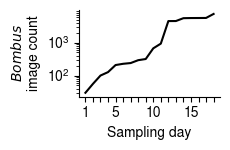

In [26]:
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
day0 = combined_df['datetime'].dt.floor('D').min()
combined_df['day'] = (combined_df['datetime'].dt.floor('D') - day0).dt.days

SKIPPED_DAYS = {6}

def day_to_display_index(d_cal: int) -> int:
    return d_cal - sum(1 for sd in SKIPPED_DAYS if sd < d_cal)

daily_counts = (
    combined_df
    .groupby('day')
    .size()
    .reset_index(name='count')
)
daily_counts['cum_count'] = daily_counts['count'].cumsum()
daily_counts = daily_counts[(daily_counts['day'] <= 18) & (~daily_counts['day'].isin(SKIPPED_DAYS))]
daily_counts['disp_day'] = daily_counts['day'].apply(day_to_display_index)

fig, ax = plt.subplots(figsize=(2.4, 1.6))

xvals = daily_counts['disp_day'] +1
ax.plot(xvals, daily_counts['cum_count'], color='black')
# ax.set_ylabel("Cumulative Bombus\nimage count")
ax.set_ylabel(r'$\it{Bombus}$' + '\nimage count')
ax.set_yscale("log")

all_days = list(range(1, 19))
ax.set_xticks(all_days)
labels = [str(d) if (d % 5 == 0 or d == 1) else "" for d in all_days]
ax.set_xticklabels(labels)

ax.set_xlabel("Sampling day")

plt.tight_layout()
plt.savefig('figs/cumulative_bombus_imgs.svg', format='svg')

In [27]:
# FINAL CUMULATIVE COUNTS PER 10K IMAGES

merge_photos_visits_filtered.groupby('color')['visits_per_10k'].sum().reset_index()

,color,visits_per_10k
0,blu,6.433264
1,blv,9.370371
2,cnt,20.830144
3,grn,14.692559
4,yel,7.127414


In [28]:
merge_photos_visits_filtered.groupby('color')['visit_count'].sum().reset_index()

,color,visit_count
0,blu,36
1,blv,54
2,cnt,95
3,grn,70
4,yel,35
